In [37]:
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint as sp_randint



In [38]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [39]:
boston = load_boston()
X = boston.data
y = boston.target
print(boston.DESCR)


.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, 
                           max_features=10, 
                           min_samples_split=2,
                           random_state=10)
score = cross_val_score(rf,X,y,cv = 5)
print('score: mean={:.2e} ; std={:.2e}'\
      .format(score.mean(),score.std()))
    

score: mean=6.42e-01 ; std=1.91e-01


In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [100,400,700,1000],
    'max_features' : [1,8,13],
    'min_samples_split' : [2,5,10]
}
clf = GridSearchCV(rf, param_grid, cv=5, verbose=1,n_jobs=4)

clf.fit(X,y)
print('GridSearch finished')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearch finished


In [42]:
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


0.457 (+/-0.388) for {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.466 (+/-0.387) for {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.465 (+/-0.411) for {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 700}
0.469 (+/-0.400) for {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.433 (+/-0.411) for {'max_features': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.438 (+/-0.415) for {'max_features': 1, 'min_samples_split': 5, 'n_estimators': 400}
0.441 (+/-0.436) for {'max_features': 1, 'min_samples_split': 5, 'n_estimators': 700}
0.452 (+/-0.412) for {'max_features': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.366 (+/-0.497) for {'max_features': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.406 (+/-0.418) for {'max_features': 1, 'min_samples_split': 10, 'n_estimators': 400}
0.411 (+/-0.445) for {'max_features': 1, 'min_samples_split': 10, 'n_estimators': 700}
0.422 (+/-0.418) for {'max_features': 1, 'min_sam

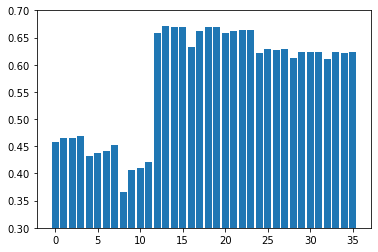

In [8]:
plt.bar(range(len(means)),means)
plt.ylim(.3,.7)
plt.show()

In [9]:
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.671 (std: 0.172)
Parameters: {'max_features': 8, 'min_samples_split': 2, 'n_estimators': 400}

Model with rank: 2
Mean validation score: 0.670 (std: 0.174)
Parameters: {'max_features': 8, 'min_samples_split': 2, 'n_estimators': 700}

Model with rank: 3
Mean validation score: 0.670 (std: 0.169)
Parameters: {'max_features': 8, 'min_samples_split': 5, 'n_estimators': 1000}



In [43]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators' : [100,400,700,1000],
    'max_features' : sp_randint(1,13),
    'min_samples_split' : sp_randint(2,10)
}
clf = RandomizedSearchCV(rf, param_dist, cv=5, n_iter=15, 
                         verbose=1,n_jobs=4, random_state=1)

clf.fit(X,y)
print('Random finished')


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random finished


In [44]:
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.674 (std: 0.173)
Parameters: {'max_features': 7, 'min_samples_split': 3, 'n_estimators': 700}

Model with rank: 2
Mean validation score: 0.673 (std: 0.164)
Parameters: {'max_features': 6, 'min_samples_split': 5, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.673 (std: 0.171)
Parameters: {'max_features': 7, 'min_samples_split': 3, 'n_estimators': 400}



In [33]:
from hyperopt import tpe, hp, fmin, space_eval

#Define the objective function to minimize
def objective(params):
    n_estimators, max_features, min_samples_split = params['n_estimators'], params['max_features'], params['min_samples_split']
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                           max_features=max_features, 
                           min_samples_split=min_samples_split,
                           random_state=10)
    score = cross_val_score(rf,X,y,cv = 5)

    return -score.mean()

In [31]:
space = {
    'n_estimators': hp.choice('n_estimators',[100,400,700,1000]),
    'max_features': hp.randint('max_features',1,13),
    'min_samples_split' : hp.randint('min_samples_split',2,10)
}

In [45]:
best = fmin(
    fn=objective, # Objective Function to optimize
    space=space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=10 # Number of optimization attempts
)
print(space_eval(space,best))

100%|██████████| 10/10 [00:45<00:00,  4.57s/trial, best loss: -0.670093703896406]
{'max_features': 8, 'min_samples_split': 3, 'n_estimators': 1000}


In [46]:
print(space_eval(space,best))

{'max_features': 8, 'min_samples_split': 3, 'n_estimators': 1000}
